## Common


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from cycler import cycler
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['legend.loc'] = 'upper left'
plt.rcParams['axes.grid.which'] = 'both'
plt.rcParams['axes.grid'] = True
plt.rcParams["savefig.bbox"] = 'tight'
# plt.rcParams['axes.spines.top'] = False
# plt.rcParams['axes.spines.right'] = False
cols = ['tab:purple', 'tab:green', 'tab:olive', 'tab:orange', 'tab:red', 'tab:pink', 'tab:cyan','tab:brown',  'tab:gray', 'tab:blue']
plt.rcParams['axes.prop_cycle'] = cycler(color=cols)
marks = ['o', 's', '^', 'D', '*', 'd', 'X', 'p', 'P', 'v']


In [2]:
import os
# os.environ["CUBLAS_WORKSPACE_CONFIG"]=":4096:8"  # makes some CUDA calls deterministic
import torch
torch.use_deterministic_algorithms(True)
# torch.set_default_tensor_type('torch.cuda.FloatTensor')
torch.set_grad_enabled(False)
torch.inference_mode(True)


In [3]:
from typing import NamedTuple
import urllib
import csv
import PIL
from torchvision.utils import make_grid
from torchvision.io import read_image
import torchvision.transforms.functional as vF
from collections import defaultdict


## Chapter 1: Intro


## Chapter 2: Interpolation


## Chapter 3: Coordinate networks


## Chapter 4: Comparison


In [4]:
# constants for indexing fields in tensors
N = 0
I = 1
H = 2
G = 3
P = 4
K = 5
PSNR = 6
TOTAL = 7
EPOCH = 8
field_count = 9


In [5]:
sigvals1ds = tuple(fname.split()[2][4:] for fname in os.listdir('../stats') if fname.startswith('H_0 D_1 sig_s'))

class Group(NamedTuple):

  @classmethod
  def H_vals(cls):
    return ('0', 'H')

  @classmethod
  def D_vals(cls):
    return (1, 2)

  @classmethod
  def sig_vals(cls):
    return ('0801_penguin', '0809_lion', '0823_greece', '0872_walnuts', '0887_castle')

  @classmethod
  def sig_vals2(cls):
    return tuple('s' + name for name in cls.sig_vals())

  @classmethod
  def sig_vals1d(cls):
    return sigvals1ds

  @classmethod
  def stype_vals(cls):
    return ('simple', 'complex')

  @classmethod
  def gen_vals(cls):
    return ('gauss', 'sinc', 'tri', 'rect')

  @classmethod
  def all(cls):
    ret = set()
    # H_0 D_1 sig_* stype_simple gen_*
    for sig in cls.sig_vals():
      for gen in cls.gen_vals():
        ret.add(Group(H='0', D=1, sig=sig, stype='simple', gen=gen))
    # H_0 D_2 sig_0823_greece stype_simple gen_sinc
    ret.add(Group(H='0', D=2, sig='0823_greece', stype='simple', gen='sinc'))
    # H_0 D_2 sig_0823_greece stype_complex gen_*
    for gen in cls.gen_vals():
      ret.add(Group(H='0', D=2, sig='0823_greece', stype='complex', gen=gen))
    # H_0 D_2 sig_* stype_complex gen_sinc
    for sig in cls.sig_vals():
      ret.add(Group(H='0', D=2, sig=sig, stype='complex', gen='sinc'))
    # H_0 D_2 sig_s* stype_complex gen_*
    for sig in cls.sig_vals2():
      for gen in cls.gen_vals():
        ret.add(Group(H='0', D=2, sig=sig, stype='complex', gen=gen))
    # H_H D_1 sig_* stype_simple gen_sinc
    for sig in cls.sig_vals():
      ret.add(Group(H='H', D=1, sig=sig, stype='simple', gen='sinc'))
    # H_H D_2 sig_0823_greece stype_simple gen_*
    for gen in cls.gen_vals():
      ret.add(Group(H='H', D=2, sig='0823_greece', stype='simple', gen=gen))
    # H_H D_2 sig_* stype_simple gen_sinc
    for sig in cls.sig_vals():
      ret.add(Group(H='H', D=2, sig=sig, stype='simple', gen='sinc'))
    # H_H D_2 sig_s0823_greece stype_simple gen_sinc
    ret.add(Group(H='H', D=2, sig='s0823_greece', stype='simple', gen='sinc'))
    return tuple(sorted(ret))
    
  H: str = 'H'
  D: int = 2
  sig: str = '0823_greece'
  stype: str = 'simple'
  gen: str = 'sinc'

  def replace(self, **kwargs):
    return self._replace(**kwargs)
  
  @property
  def fname(self):
    return f'H_{self.H} D_{self.D} sig_{self.sig} type_{self.stype} gen_{self.gen}.csv'
  
  @property
  def url(self):
    return "https://raw.githubusercontent.com/amackay/hpcode/main/stats/" + self.fname.replace(' ', '%20')
  
  @property
  def tmpdir(self):
    return './tmp'
  
  @property
  def tmppath(self):
    return os.path.join(self.tmpdir, self.fname)

  @property
  def localpath(self):
    return os.path.join('../stats', self.fname)


In [6]:

def get_file_path(g: Group):
  if os.path.exists(g.localpath):
    return g.localpath
  os.makedirs(g.tmpdir, exist_ok=True)
  if not os.path.exists(g.tmppath):
    urllib.request.urlretrieve(g.url, g.tmppath)
  return g.tmppath


In [7]:

def csv_to_tens(g: Group):
  rows = []
  with open(get_file_path(g), newline='') as f:
    reader = csv.DictReader(f)
    for row in reader:
      rows.append(row)
  t = torch.zeros((len(rows), field_count))
  for i, row in enumerate(rows):
    for k in list(row.keys()):
      row[k] = float(row[k])
    t[i][N] = row['N']
    t[i][I] = row['I']
    t[i][H] = row['H']
    t[i][G] = row['G']
    t[i][P] = row['P']
    t[i][K] = row['K']
    t[i][PSNR] = row['psnr']
    t[i][TOTAL] = row['total_time']
    t[i][EPOCH] = row['epoch_time']
  return t


In [8]:

class Data(object):
  def __init__(self):
    self.cache = {}
  
  def __getitem__(self, key):
    if key not in self.cache:
      self.cache[key] = csv_to_tens(key)
    return self.cache[key]

data = Data()

def datamean(g: Group):
  if g.H == 'H':
    raise NotImplementedError
  if g.sig == '2ds':
    sigs = Group.sig_vals2()
  elif g.sig == '1ds':
    sigs = Group.sig_vals1d()
  elif g.sig[0] == '0':
    sigs = Group.sig_vals()
  else:
    raise NotImplementedError
  ts = [data[g.replace(sig=sig)] for sig in sigs]
  return sum(ts) / len(ts)


In [9]:

def title(a, t):
  if t:
    a.set_title(t)
  a.set_xlabel('Parameter count')
  a.set_ylabel('PSNR')


### Dataset

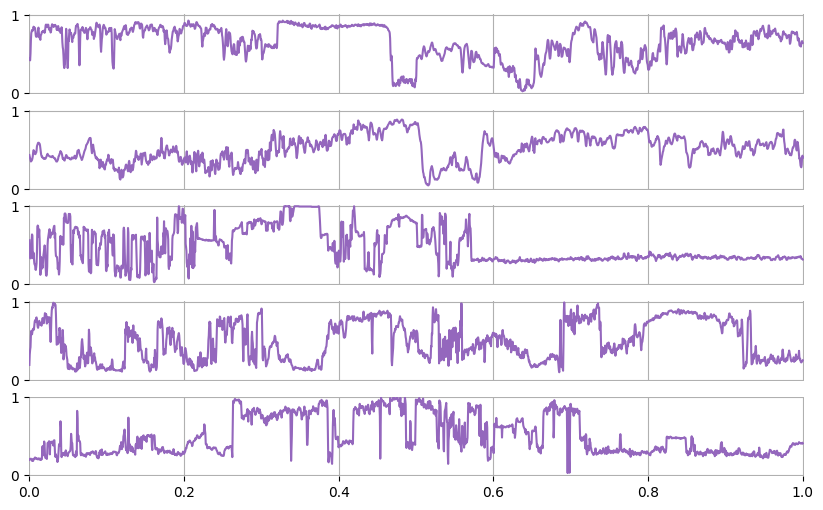

In [10]:
def show_sigs():
  sigs = tuple(sorted(Group.sig_vals()))
  imgs = []
  for sig in sigs:
    imgs.append(PIL.Image.open('../../exps/1d/' + sig + '.png'))
  fig, ax = plt.subplots(nrows=len(imgs), sharex=True)
  for i in range(len(imgs)):
    y = vF.to_tensor(imgs[i]).squeeze()
    x = torch.arange(len(y)) / (len(y) - 1)
    ax[i].plot(x, y)
    ax[i].set_ylim(-0.01,1.01)
    ax[i].set_xlim(-0.001,1.001)
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['bottom'].set_visible(False)
    ax[i].spines['left'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    if i != len(imgs) - 1:
      ax[i].tick_params(axis='x', bottom=False)
  return fig

show_sigs().savefig('../charts/sig1d_egs.png')

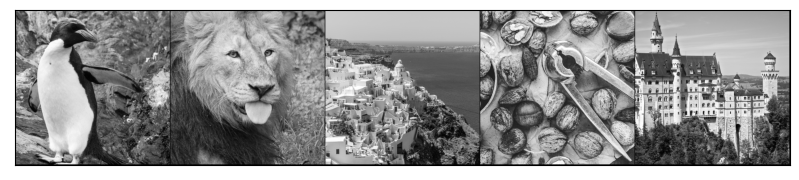

In [11]:
def showimgs():
  sigs = tuple(sorted(Group.sig_vals2()))
  imgs = []
  for sig in sigs:
    imgs.append(read_image('../../exps/2d/' + sig + '.png'))
  total = vF.to_pil_image(make_grid(imgs))

  fig, ax = plt.subplots()
  ax.imshow(total, cmap='gray')
  ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
  return fig

showimgs().savefig('../charts/5images.png')


### Generating functions


In [12]:

def plot_1d_CF(ylims=None, xlog=False, rel=False, xlo=None, xhi=None):
  fig, ax = plt.subplots()
  gens = Group.gen_vals()
  ts = [datamean(Group(H='0', D=1, sig='0', stype='simple', gen=gen)) for gen in gens]
  mean = sum(ts) / len(ts)
  for gen, t in zip(gens, ts):
    if rel:
      t[:,PSNR] -= mean[:,PSNR]
    if xlo:
      t = t[t[:,P] >= xlo]
    if xhi:
      t = t[t[:,P] <= xhi]
    if gen == 'gauss':
      gen = 'Gauss'
    ax.plot(t[:,P], t[:,PSNR], label=f'{gen}', alpha=0.8)
  if xlog:
    ax.set_xscale('log')
  if ylims:
    ax.set_ylim(ylims)
  ax.legend()
  title(ax, '')
  if rel:
    ax.set_ylabel('Relative PSNR')
    ax.legend(loc='lower left')
  return fig


def plot_2d_CF(xlog=False, rel=False, xlo=None, xhi=None):
  fig, ax = plt.subplots()
  gens = Group.gen_vals()
  ts = [datamean(Group(H='0', D=2, sig='2ds', stype='complex', gen=gen)) for gen in gens]
  mean = sum(ts) / len(ts)
  for gen, t in zip(gens, ts):
    if rel:
      t[:,PSNR] -= mean[:,PSNR]
    if xlo:
      t = t[t[:,P] >= xlo]
    if xhi:
      t = t[t[:,P] <= xhi]
    if gen == 'gauss':
      gen = 'Gauss'
    ax.plot(t[:,P], t[:,PSNR], label=f'{gen}', alpha=0.8)
  # ax.set_ylim(14, 60)
  if xlog:
    ax.set_xscale('log')
  ax.legend()
  title(ax, '')
  if rel:
    ax.set_ylabel('Relative PSNR')
    ax.legend(loc='lower left')
  return fig


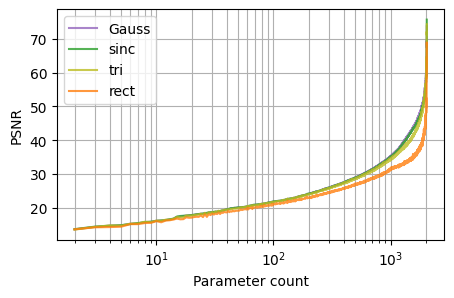

In [13]:
plt.rcParams['figure.figsize'] = (5, 3)
plot_1d_CF(xlog=True, xhi = 2039).savefig('../charts/1d_gen_fns_logx.png')
plt.rcParams['figure.figsize'] = (10, 6)


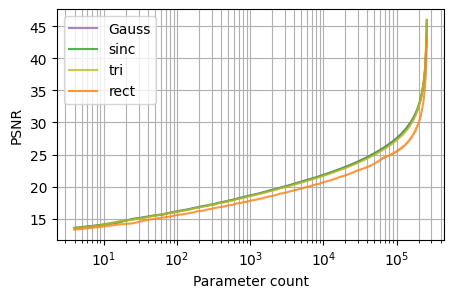

In [14]:
plt.rcParams['figure.figsize'] = (5, 3)
plot_2d_CF(xlog=True, xhi=26e4).savefig('../charts/2d_gen_fns_logx.png')
plt.rcParams['figure.figsize'] = (10, 6)


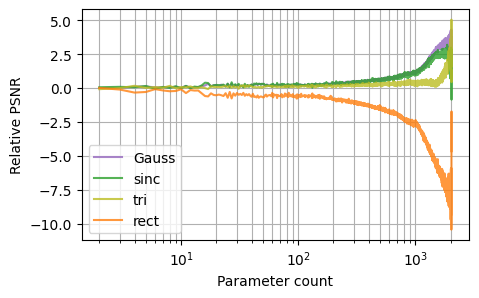

In [15]:
plt.rcParams['figure.figsize'] = (5, 3)
plot_1d_CF(xlog=True, xhi = 2039, ylims=None, rel=True).savefig('../charts/1d_gen_fns_logx_rel.png')
plt.rcParams['figure.figsize'] = (10, 6)


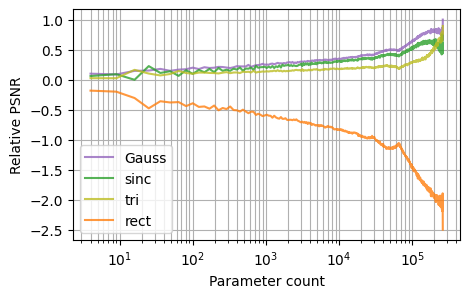

In [16]:
plt.rcParams['figure.figsize'] = (5, 3)
plot_2d_CF(xlog=True, xhi=2.621e5, rel=True).savefig('../charts/2d_gen_fns_logx_rel.png')
plt.rcParams['figure.figsize'] = (10, 6)


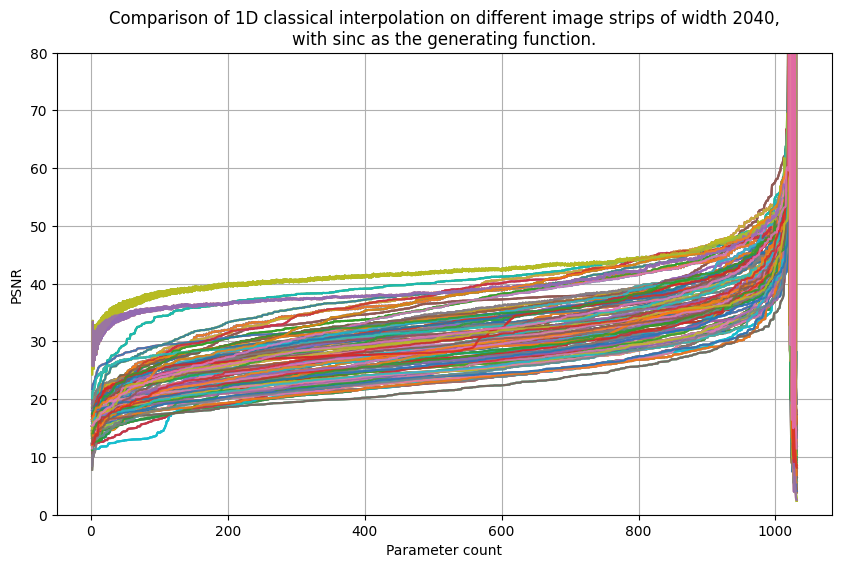

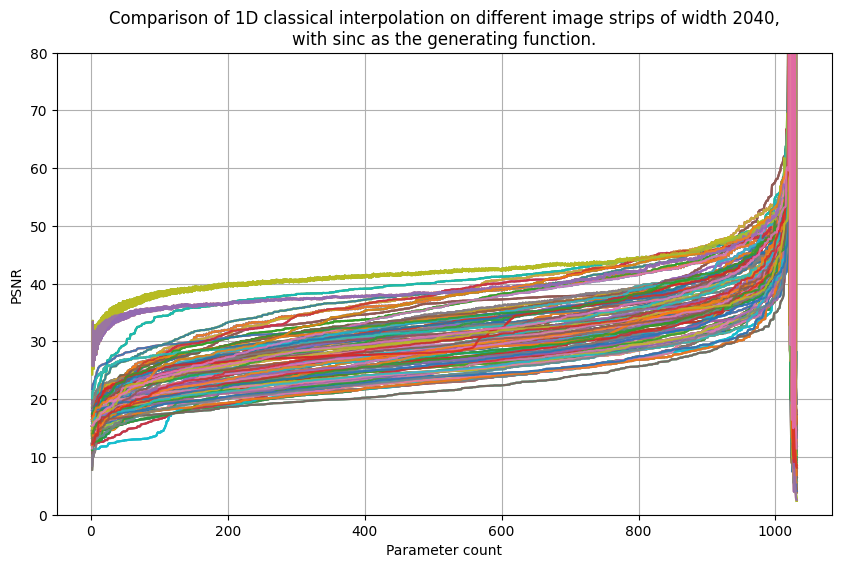

In [17]:
def plot_1d_sigs_CF():
  fig, ax = plt.subplots()
  for sig in Group.sig_vals1d():
    t = data[Group(H='0', D=1, sig=sig, stype='simple', gen='sinc')]
    ax.plot(t[:,P], t[:,PSNR], label=f'{sig}.png', alpha=0.8)
  ax.set_ylim(0, 80)
  # ax.legend()
  title(
    ax,
    '\n'.join([
      'Comparison of 1D classical interpolation on different image strips of width 2040,',
      'with sinc as the generating function.',
    ]),
  )
  return fig

plot_1d_sigs_CF()

### Coordinate network depths


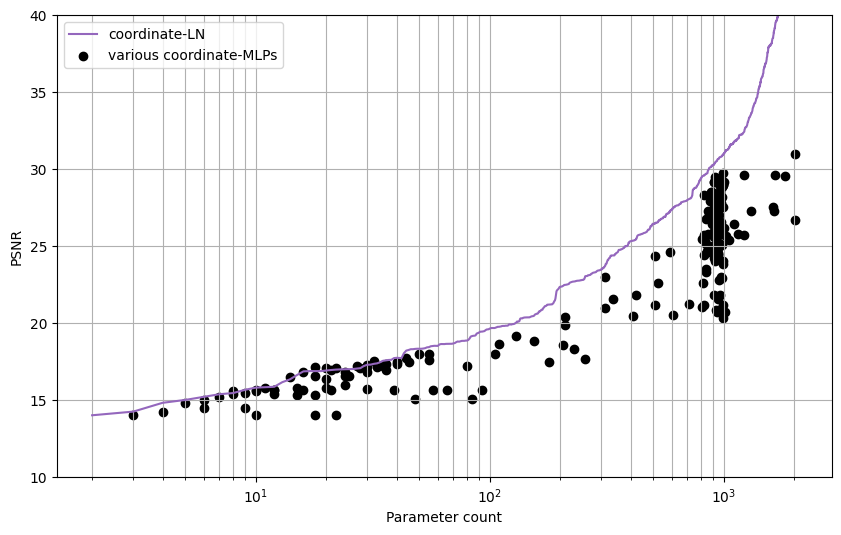

In [18]:

def plot_1d_sinc_CF(ax):
  t = data[Group(H='0', D=1)]
  ax.plot(t[:,P], t[:,PSNR], label=f'coordinate-LN')
  ax.set_ylim(14, 60)
  ax.legend()

def plot_1d_greece_CN():
  fig, ax = plt.subplots(nrows=1)
  plot_1d_sinc_CF(ax)
  t = data[Group(H='H', D=1)]
  ax.scatter(t[:,P], t[:,PSNR], label=f'various coordinate-MLPs', c='black')
  ax.set_ylim(10, 40)
  ax.set_xscale('log')
  ax.legend()
  title(ax, '')
  return fig


plot_1d_greece_CN().savefig('../charts/1d_CNs.png')


In [19]:
def chart_2d_sgreece_CN_diffs(rel=False, xlo=8, xhi=384, hhi=8):
  fig, ax = plt.subplots(nrows=1)
  cc = data[Group(H='0', D=2, sig='s0823_greece', stype='complex')]
  cc = cc[cc[:,N] <= xhi * 1.25]
  cc = cc[cc[:,N] >= xlo * 0.75]
  if rel:
    cc[:,PSNR] -= cc[:,PSNR]
  ax.plot(cc[:,P], cc[:,PSNR], label=f'coordinate-LN', c='black', ls=':')
  g = Group(H='H', D=2, sig='s0823_greece', stype='simple')
  t = data[g]
  t = t[torch.argsort(t[:,N], 0)]
  if xhi:
    t = t[t[:,N] <= xhi]
  if xlo:
    t = t[t[:,N] >= xlo]
  for i,h in enumerate(range(1, hhi+1)):
    th = t[t[:,H] == h]
    cc = data[Group(H='0', D=2, sig='s0823_greece', stype='complex')]
    cc = cc[th[:,N].type(torch.long) - 2]
    if rel:
      th[:,PSNR] -= cc[:,PSNR]
    ax.plot(th[:,P], th[:,PSNR], marker=f'${h}$', label=f'H = {h}', alpha=0.8)#, cmap=plt.get_cmap('viridis', maxH), c=h)
  ax.set_xscale('log')
  # ax.set_ylim(-.5, 1.6)
  ax.legend()
  title(ax, '')
  if rel:
    ax.set_ylabel('Relative PSNR')
  return fig


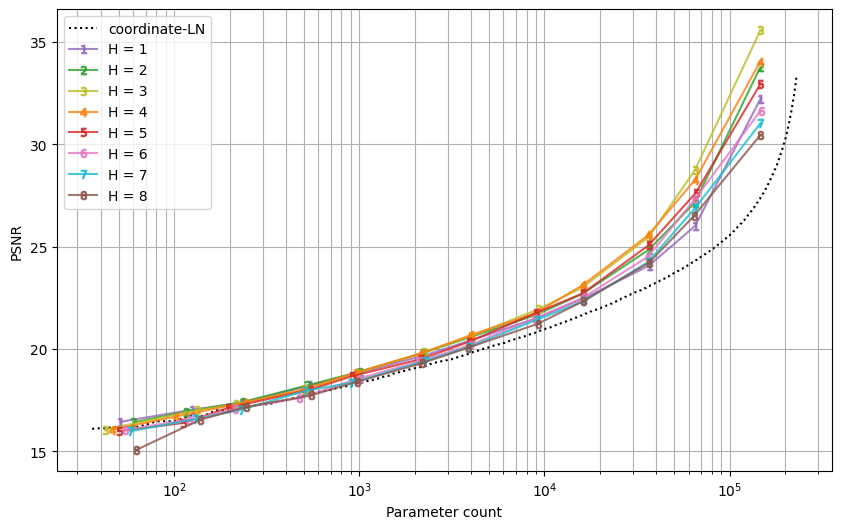

In [20]:
chart_2d_sgreece_CN_diffs(rel=False).savefig('../charts/plend_greece_abs.png')

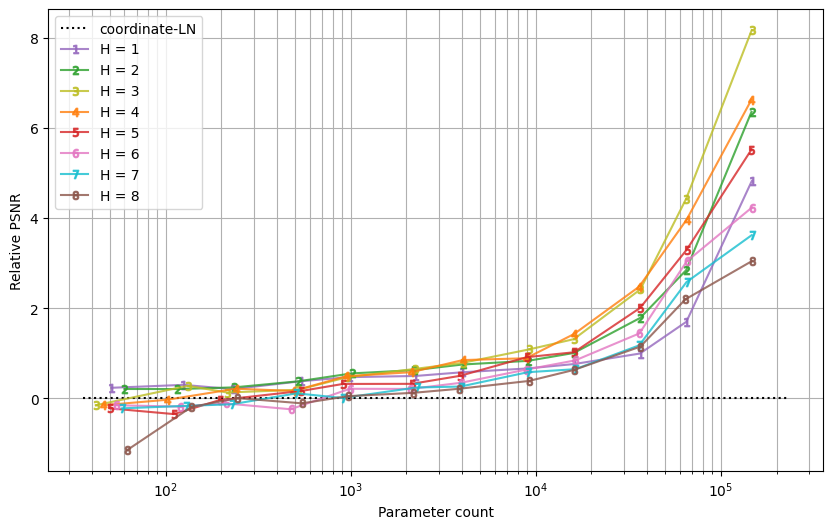

In [21]:
chart_2d_sgreece_CN_diffs(rel=True, hhi=8).savefig('../charts/plend_greece_h0to8.png')

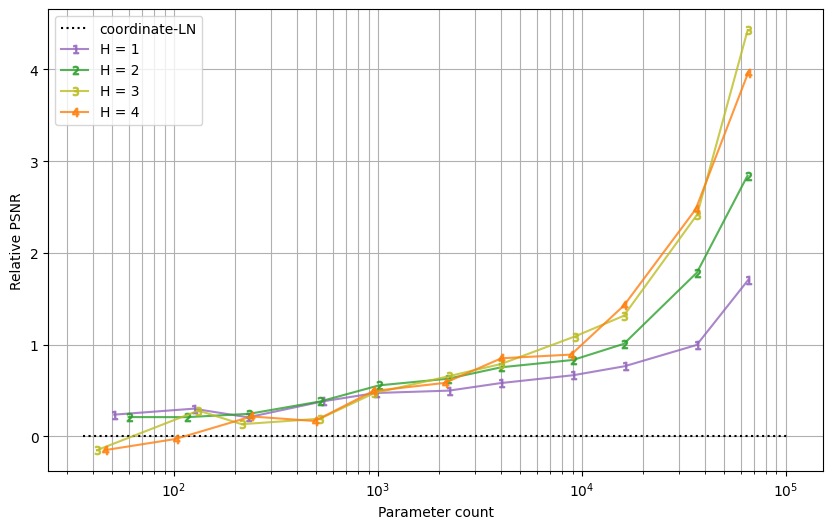

In [22]:
chart_2d_sgreece_CN_diffs(rel=True, xhi=256, hhi=4).savefig('../charts/plend_greece_h0to4.png')

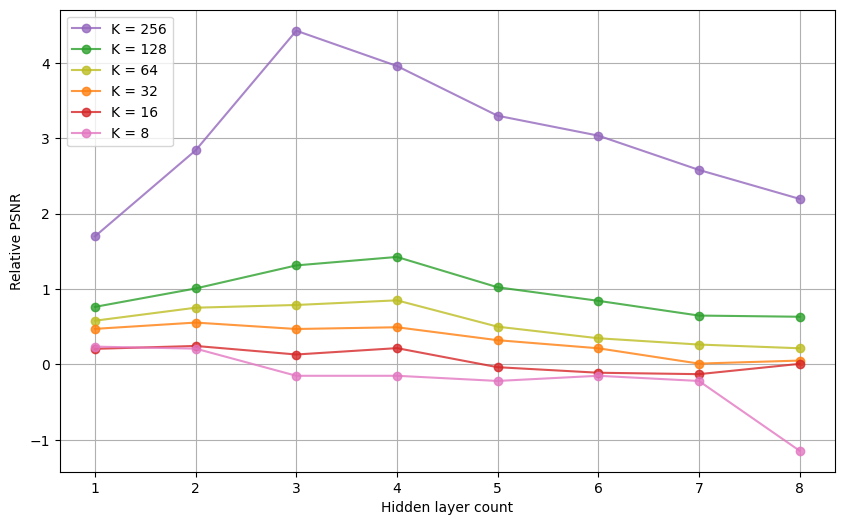

In [23]:

def chart_by_depth():
  cc = data[Group(H='0', D=2, sig='s0823_greece', stype='complex')]
  t = data[Group(H='H', D=2, sig='s0823_greece', stype='simple')]
  Hs = [1,2,3,4,5,6,7,8]
  Ns = [8, 16, 32, 64, 128, 256]
  Ns.reverse()
  fig, ax = plt.subplots()
  for n in Ns:
    ccn = cc[cc[:,N] == n][0,PSNR].item()
    tt = t[t[:,N] == n]
    ys = []
    for h in Hs:
      ys.append(tt[tt[:,H] == h][0,PSNR].item() - ccn)
    av = sum(ys)/len(ys)
    # ys = [y / av for y in ys]
    ax.plot(Hs, ys, marker=f'o', label=f'K = {n}', alpha=0.8)#, cmap=plt.get_cmap('viridis', maxH), c=h)
  ax.legend()
  title(ax, '')
  ax.set_xlabel('Hidden layer count')
  ax.set_ylabel('Relative PSNR')
  return fig

chart_by_depth().savefig('../charts/plend_greece_byh.png')


### Param counts


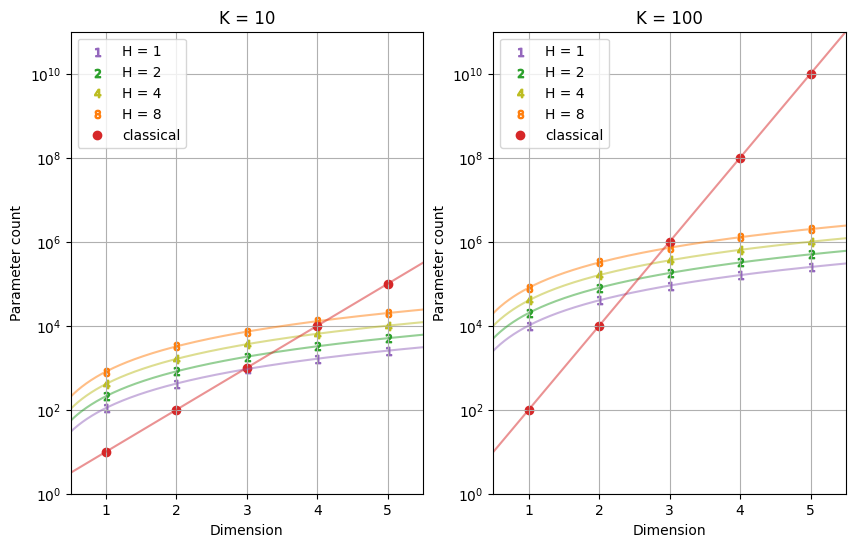

In [24]:
def chart_paramcounts():
  Ks = [10, 100]
  Hs = [1, 2, 4, 8]
  fig, axs = plt.subplots(ncols=len(Ks))
  ds = torch.arange(501) / 100 + 0.5
  intinds = torch.tensor([50, 150, 250, 350, 450])
  for K, ax in zip(Ks, axs):
    for H in Hs:
      ps = H * K**2 * torch.pow(ds, 2) + K * ds
      ax.plot(ds, ps, alpha=0.5)
      ax.scatter(ds[intinds], ps[intinds], marker=f'${H}$', label=f'H = {H}')
    ps = torch.pow(K, ds)
    ax.plot(ds, ps, alpha=0.5)
    ax.scatter(ds[intinds], ps[intinds], label='classical')
    ax.set_yscale('log')
    ax.set_ylim(1e0, 1e11)
    ax.set_xlim(0.5, 5.5)
    ax.set_xlabel('Dimension')
    ax.set_ylabel('Parameter count')
    ax.set_title(f'K = {K}')
    ax.legend()
  return fig

chart_paramcounts().savefig('../charts/paramcounts.png')

## Chapter 5: Conclusions
